# Explore spatial averaging for multi frequency omni antennas
This version calculates all antennas together

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 30/5/2023

+ FEKO data provided by Danie Ludick
+ Uses **v11** RFcalcUC module
+ Incorporates antenna data using the *updated tissue dielectric values*

## Load necessary python modules

In [16]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from importlib import reload
from scipy.interpolate import interp1d, interp2d, griddata
import seaborn as sn
from scipy import stats
from scipy import interpolate
from collections import namedtuple
from collections.abc import Iterable
import textwrap as tr
import pandas as pd
import RFcalcUC_v11 as RFcalcUC
from RFcalcUC_v11 import *
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set current working directory to the notebook folder
%cd -0
%cd ../
plotdir = './antennas/omni/plots/'
antdir = './antennas/'

# C:\Users\emeau\Dropbox\Spat avg WG\Data\Monopole antenna\400MHz

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks
C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg


## Functions

In [17]:
def getgrid(df):
    '''Create a dataframe of a grid's characteristics:
       min, max, n, delta'''
    
    def n(arr):
        '''Return number of unique elements in array'''
        return arr.unique().size

    def max_delta(arr):
        '''Return dx or dz increment between x or z points'''
        return np.diff(np.sort(np.unique(arr))).max()
   
    grid = df[['x','z']].agg(['min','max',n,max_delta]).T
    grid['n'] = grid.n.astype(int)
    return grid

def dB(x):
    return 10. * np.log10(x)

def omni_length(fMHz):
    wl = 300 / fMHz           # wavelength
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    length = 3*dipole_sep + dipole_len
    return length

def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

def confunc(arr, Si, convector):
    """Returns numpy array for convolution transformation of S values
       Is used to do vertical spatial averaging
              Si = The column of S to be spatially averaged, e.g. Smax, Sfac, etc
       convector = the convolution vector, e.g. np.ones(21)/21 for 2 meter averaging 
                   with 0.1m intervals over 21 points
    """
    return np.convolve(arr[Si].values, convector, 'same')

def spatavg(df, name, Si, convector):
    """Creates a column in the S dataframe for spatially averaged field
       values in the z (i.e. vertical) orientation
            name = the name of the new column, e.g. 'Sfac_avg'
              Si = The column of S to be spatially averaged, e.g. Smax, Sfac, etc
       convector = the convolution vector for the spatial averaging, e.g. np.ones(21)/21 for 2 meter averaging
    """
    print(f'creating {name} spatial average of {Si}')
    Savg = df[['x', 'y', Si]].groupby(['x', 'y']).apply(confunc, Si, convector, )
    Savg = np.concatenate(Savg.to_list())
        
    return Savg
    
def make_mgrid(df,c):
    '''Make an xz mgrid for column c'''
    df = df.sort_values(['x','z'])
    nx = len(df.x.unique())
    nz = len(df.z.unique())
    C = df[c].values.reshape(nx, nz)
    return C

def complot(df,fMHz,setting,S='Smax-1.6m-5',figsize=(6,4),
            axes=[],axi=0,fig=None,plot_title=''):
    '''Plot the compliance boundaries for Smax and SAR in xz plane
       and depict the omni antenna in the plot at x=0, z=0
       df = data dataframe containing x,y,z,Smax,Ssa,SAR data
       fMHz = frequency of model (used for scaling of omni elements)
       ax = matplotlib axis to plot to. Default of '[]' generates a new figure
       fig = matplotlib figure to plot to. Default of 'None' uses current figure
       setting = seting for exposure limits ['pub' or 'occ']
    '''
    
    # Get S and SAR limit levels
    limS = Slimit(fMHz, setting=setting, standard='RPS S-1 WB')
    limSAR = SARlimit('pub')
    
    # make mgrids for x, z, S, SAR
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    Smax = make_mgrid(df,'Smax')
    Ssa = make_mgrid(df,S)
    SAR = make_mgrid(df,'SARwbi')
    
    # Specify fig and axes for the plot
    if len(axes) == 0:
        fig, axes = plt.subplots(figsize=figsize)
    if fig == None:
        fig = plt.gcf()
    axes = np.array(axes).flatten()
    ax = axes[axi]

    # Contour plots for S and SAR
    CS1 = ax.contour(X, Z, Smax, levels=[limS], colors=['green'], linewidths=0.6)
    CS2 = ax.contour(X, Z, SAR, levels=[limSAR], colors=['red'], linewidths=0.6)
    CS3 = ax.contour(X, Z, Ssa, levels=[limS], colors=['blue'], linewidths=0.6)

    # Add named contour lables at Z=1 for each data set
    fmt1 = {limS:'Smax'}
    fmt2 = {limSAR:'SAR'}
    fmt3 = {limS:'Ssa'}

    # Label every other level using strings
    ax.clabel(CS1, CS1.levels, inline=True, fmt=fmt1, fontsize=8)
    ax.clabel(CS2, CS2.levels, inline=True, fmt=fmt2, fontsize=8)
    ax.clabel(CS3, CS3.levels, inline=True, fmt=fmt3, fontsize=8)

    # Label axes and plot and display grid
    ax.set_title(f"WBA SAR, Smax and {S}\ncompliance zones",fontsize=9)
    text = f'{fMHz} MHz'
    ax.text(0.96, 0.9, text, horizontalalignment='right',verticalalignment='center',
            transform=axes[i].transAxes,fontsize=14, color='b')
    text = f'{setting} limits:\n{limS} W/m²\n{limSAR} W/kg'
    ax.text(0.96, 0.15, text, horizontalalignment='right',verticalalignment='center',
            transform=axes[i].transAxes,fontsize=10, color='black')
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')

    # Draw omni antenna
    wl = 300 / fMHz           # wavelength
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    zdcs = [dipole_sep * i for i in [-1.5,-0.5,0.5,1.5]]  # z for dipole centres
    
    for zdc in zdcs:
        zlow  = zdc - dipole_len / 2
        zhigh = zdc + dipole_len / 2
        ax.plot([0,0],[zlow,zhigh],'b-',lw=3)
        ax.plot(0,zdc,'ro',markersize=3)
        
    # finish off figure
    if plot_title != '':
        fig.suptitle(plot_title, color='r', fontsize=16)
    fig.tight_layout()
        
def addR(df, Ssa, fMHz):
    '''Add a column in df for R where R=(Ssa/Slim)/(SARwbi/SARlim)
       INPUTS:
       df = data dataframe
       Ssa = column name for spatial average values
       fMHz = frequency of exposure in MHz'''
    
    # Get limit values
    Slim = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
    SARlim = SARlimit(setting='pub')
    
    # Add R column to df
    Rcol = f'R-{Ssa}'
    df[Rcol] = (df[Ssa]/Slim) / (df.SARwbi/SARlim)
    
    return df 
    
def contourplotR(df,col,fMHz,levels=None,dB=False,R=False):
    '''Generate contour plot of df[col] in xz plane
       Depict the omni antenna in the plot at x=0, z=0
       INPUTS:
       df = data dataframe containing x,y,z,Smax,Ssa,SAR data
       col = data column name in df, e.g. "R1.6m-5        
       fMHz = frequency of the exposure in MHz (used for scaling antenna)
       levels = contour levels
       dB = switch for plotting R: True -> plot dB(R), False -> plot R
       R = switch for indicating compliance ration data
    '''
    
    # make mgrids for x, z, S, SAR
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    C = make_mgrid(df,col)
    if dB == True: 
        C = 10. * np.log10(C)    
    
    # Create plot title
    if R == True:
        title = f"compliance ratio for {col[2:]}"
        if dB == True:
            title = "dB " + title
    else:
        title = col if dB == False else f"dB({col})"
    title = title + f" at {fMHz} MHz"
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8,8))

    # Contour plots for R
    levels = np.linspace(0,10,11)
    CS1 = ax.contourf(X, Z, C, levels=levels)

    # Label axes and plot and display grid
    fig.suptitle(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')

    # Draw omni antenna
    wl = 300 / fMHz           # wavelength
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    zdcs = [dipole_sep * i for i in [-1.5,-0.5,0.5,1.5]]  # z for dipole centres
    
    for zdc in zdcs:
        zlow =  zdc - dipole_len / 2
        zhigh = zdc + dipole_len / 2
        ax.plot([0,0],[zlow,zhigh],'b-',lw=4)
        ax.plot(0,zdc,'ro')
        
def weighted_percentile(a, q=np.array([75, 25]), w=None):
    """
    Calculates percentiles associated with a (possibly weighted) array

    Parameters
    ----------
    a : array-like
        The input array from which to calculate percents
    q : array-like
        The percentiles to calculate (0.0 - 100.0)
    w : array-like, optional
        The weights to assign to values of a.  Equal weighting if None
        is specified

    Returns
    -------
    values : np.array
        The values associated with the specified percentiles.  
    """
    # Force a, q and w to numpy arrays
    a = np.asarray(a)
    if not isinstance(q, Iterable):
        q = [q]
    q = np.asarray(q) / 100.0
    if w is None:
        w = np.ones(a.size)
    else:
        w = np.asarray(w)
        
    # Standardize and sort based on values in a
    idx = np.argsort(a)
    a_sort = a[idx]
    w_sort = w[idx]

    # Get the cumulative sum of weights
    ecdf = np.cumsum(w_sort)

    # Find the percentile index positions associated with the percentiles
    p = q * (w.sum() - 1)

    # Find the bounding indices (both low and high)
    idx_low = np.searchsorted(ecdf, p, side='right')
    idx_high = np.searchsorted(ecdf, p + 1, side='right')
    idx_high[idx_high > ecdf.size - 1] = ecdf.size - 1

    # Calculate the weights 
    weights_high = p - np.floor(p)
    weights_low = 1.0 - weights_high

    # Extract the low/high indexes and multiply by the corresponding weights
    x1 = np.take(a_sort, idx_low) * weights_low
    x2 = np.take(a_sort, idx_high) * weights_high

    # Return the average
    return np.add(x1, x2)

## Look at model metadata for the spatial averaging trials

In [18]:
# Read in "calc uc trials.xls" spreadsheet
trialdata = pd.read_excel(antdir + 'spat avg trials.xlsx', 'trials', 
                          skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trialdata

,unit,1,2,3,4,5,6,7,8,9
INPUT,,,,,,,,,,
fMHz,MHz,900,900,900,70,180,400,700,1000,2320
antenna,,IEC 62232 panel antenna,IEC 62232 panel antenna,Yagi,Omni,Omni,Omni,Omni,Omni,Yagi
Prad,W,80,200,100,100,100,100,100,100,1
dBiGain,,,,,7.37,7.38,7.38,7.38,7.38,
horizHPBW,deg,,,,360,360,360,360,360,
vertHPBW,deg,,,,20.3,20.3,20.3,20.3,20.3,
coordinate_origin,,centre of the middle feed segment,centre of the middle feed segment,centre of rear reflector,centre of omni,centre of omni,centre of omni,centre of omni,centre of omni,centre of rear reflector
xstart,m,0.5,-1,-1,0.05,0.05,0.05,0.05,0.05,-10
xend,m,14,14,5,5.05,5.05,5.05,5.05,5.05,50


## Read in the E and H data from the FEKO zip files

In [19]:
# Set the trials
trials = [4,5,6,7,8]

# Create empty data frame for S data
S = pd.DataFrame(columns=['trial','fMHz','x','y','z','rxy','SE','SH','Smax'])

# Get S data for each trial
for trial in trials:
    # Get E and H FEKO data file locations
    t = trialdata[str(trial)]
    datadir = f'./antennas/{t.antenna_folder}/data/'
    Efile = t.FEKO_Efile
    Hfile = t.FEKO_Hfile

    # Read in E-field FEKO data
    print(f'{Efile = }')
    Enames = ['x','y','z','Exr','Exi','Eyr','Eyi','Ezr','Ezi']
    Edat = pd.read_csv(datadir + Efile, sep='\s+', skiprows=17, names=Enames)
    Edat = Edat.sort_values(['x','z'])

    # Read in H-field FEKO data
    print(f'{Hfile = }')
    Hnames = ['x','y','z','Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']
    Hdat = pd.read_csv(datadir + Hfile, sep='\s+', skiprows=17, names=Hnames)
    Hdat = Hdat.sort_values(['x','z'])

    # Calculate SE, SH, Smax
    SE = 0.5 * Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
    SH = 0.5 * Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377
    Smax = np.max([SE,SH],axis=0)

    # Create trial dataframe
    Strial = pd.DataFrame(dict(trial=trial,fMHz=t.fMHz,x=Edat.x,y=Edat.y,z=Edat.z,
                               SE=SE,SH=SH,Smax=Smax)).reset_index(drop=True)
    
    # Append Strial to S dataframe
    S = pd.concat([S,Strial])
    
# Calculate radial distance in xy plane, rxy
S['rxy'] = np.sqrt(S.x**2 + S.y**2)

Efile = 'CELW_PD620_70MHz_monopole.efe'
Hfile = 'CELW_PD620_70MHz_monopole.hfe'
Efile = 'CELW_PD620_180MHz_monopole.efe'
Hfile = 'CELW_PD620_180MHz_monopole.hfe'
Efile = 'CELW_PD620_400MHz_monopole.efe.zip'
Hfile = 'CELW_PD620_400MHz_monopole.hfe.zip'
Efile = 'CELW_PD620_700MHz_monopole.efe'
Hfile = 'CELW_PD620_700MHz_monopole.hfe'
Efile = 'CELW_PD620_1000MHz_monopole.efe'
Hfile = 'CELW_PD620_1000MHz_monopole.hfe'


## Get SAR data

In [20]:
# Create empty SAR dataframe
SARdf0 = pd.DataFrame(columns=['trial','fMHz','x','y','z','SARwb'])

for trial in trials:
    t = trialdata[str(trial)]
    datadir = f'./antennas/{t.antenna_folder}/data/'
    
    # Read in csv data file
    SARdftrial = pd.read_csv(datadir + t.SAR_file, usecols=[0,1,2,4]).astype(float)
    SARdftrial.columns = ['x','y','z','SARwb']
    SARdftrial['trial'] = trial
    SARdftrial['fMHz'] = t.fMHz
    
    # Concatenate SARdftrial to SARdf0
    SARdf0 = pd.concat([SARdf0,SARdftrial],ignore_index=True,verify_integrity=True)
    
    # Print unique values in x,y,z, columns
    print(f'{t.fMHz} MHz: {t.SAR_file} ')
    print('x values:', *SARdftrial.x.unique())
    print('y values:', *SARdftrial.y.unique())
    print('z values:', *SARdftrial.z.unique(), '\n')

# Replace zero values with 5E-6
SARdf0['SARwb'] = SARdf0['SARwb'].replace(0, 5E-6) 
    
SARdf0.query("z==0")

70 MHz: wbSAR-70MHz-monopole-2022-12-15.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 3.9 5.0
y values: 0.0
z values: -12.0 -9.0 -6.0 -4.0 -2.5 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.5 4.0 6.0 9.0 12.0 

180 MHz: wbSAR-180MHz-monopole.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 3.9 5.0
y values: 0.0
z values: -5.0 -4.0 -3.2 -2.4 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.4 3.2 4.0 5.0 

400 MHz: wbSAR-400MHz-monopole-2022-12-15.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 3.9 5.0
y values: 0.0
z values: -2.5 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.5 

700 MHz: wbSAR-700MHz-monopole-2022-12-15.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 4.0
y values: 0.0
z values: -4.0 -3.2 -2.4 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.4 3.2 4.0 

1000 MHz: wbSAR-1000MHz-monopole-2022-12-15.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 4.0
y values: 0.0
z values: -3.8 -3.0 -2.3 -1.6 -1.0 -0.5 0.0 0.5 1.0 1.6 2.3 3.0 3.8 



,trial,fMHz,x,y,z,SARwb
8,4,70,0.05,0.0,0.0,0.458670
25,4,70,0.10,0.0,0.0,0.408700
42,4,70,0.30,0.0,0.0,0.246020
59,4,70,0.60,0.0,0.0,0.119420
76,4,70,1.00,0.0,0.0,0.057709
93,4,70,1.50,0.0,0.0,0.037877
110,4,70,2.20,0.0,0.0,0.032632
127,4,70,3.00,0.0,0.0,0.027282
144,4,70,3.90,0.0,0.0,0.019516
161,4,70,5.00,0.0,0.0,0.015821


### Interpolation functions

In [21]:
def axisvals(axis, delta, df):
    '''Generate points for axis in df for delta increment'''
    minval = df[axis].min()
    maxval = df[axis].max()
    return np.arange(minval, maxval+delta, delta).round(8)

def SARinterpolator1d(df, ax1, newaxisvals, kind):
    '''Interpolate SARwb values in df along specified x, y or z axis
    INPUTS:
      df = input dataframe
      ax1 = axis to intepolate along ['x', 'y' or 'z']
      newaxisvals = interpolation points along the ax1 axis
      kind = type of interpolation [linear, quadractic, cubic, etc]
    OUTPUTS:
      df1 = dataframe with interpolated SARwb values
      '''
    print(f'{kind} log interpolation along the {ax1} axis ...')
    
    # Get axis names for ax2, ax3
    other_axes = dict(x=('y','z'),y=('x','z'),z=('x','y'))
    ax2, ax3 = other_axes[ax1]
    
    # Create empty dataframe
    df1 = pd.DataFrame(columns=('x','y','z','SARwb')) # initialise empty dataframe
    
    # Groupby over ax2 and ax3 axes
    for (ax2val,ax3val), g in df.groupby([ax2, ax3]):
        
        # get xx, yy interpolation arrays and remove elements where yy is nan 
        xx = g[ax1].values.astype(np.float64)
        yy = g.SARwb.values.astype(np.float64)
        mask = np.isnan(yy)
        xx = xx[~mask]
        yy = yy[~mask]
        if 0 in yy:
            print(f'{ax2}={ax2val}, {ax3}={ax3val}')
            print(yy)           
        yy = np.log10(yy)
        
        # Create 1d interpolation function
        f = interp1d(xx, yy, kind=kind, fill_value='extrapolate')
        ff = lambda newaxisvals: 10**f(newaxisvals)
    
        # do interpolation over ax1 axis
        SARwb = ff(newaxisvals)
        dfi = pd.DataFrame({ax1:newaxisvals, ax2:ax2val, ax3:ax3val, 'SARwb':SARwb})
        df1 = pd.concat([df1, dfi])
        
    df1 = df1.sort_values(['x','y','z']).reset_index(drop=True)
    return df1.astype(float)

### Interpolate SARdfall over x, y & z axes

In [22]:
# Create empty SAR dataframe
SARdfi_all = pd.DataFrame(columns=['x','y','z','SARwbi','trial'])

for trial in trials:
    t = trialdata[str(trial)]
    fMHz = t.fMHz
    Strial = S[S.trial == trial]
    SARtrial = SARdf0[SARdf0.trial == trial]

    # Set interpolation parameters
    delta = 0.1                          # increment axis points
    xnew = axisvals('x', delta, Strial)  # new x-value interpolation points
    znew = axisvals('z', delta, Strial)  # new z-value interpolation points

    # Conduct x, y and z axis interpolations
    SARdfi_x = SARinterpolator1d(SARtrial,'x',xnew,'quadratic')
    SARdfi_xz = SARinterpolator1d(SARdfi_x,'z',znew,'quadratic')

    # Rename SARwb to SARwbi
    SARdfi_xz.rename(columns={'SARwb':'SARwbi'},inplace=True)    
    
    # Add trial column
    SARdfi_xz['trial'] = trial
    print(f'\n{fMHz} MHz')
    # display(SARdfi_xz)
    
    # Concatenate trial data to SARdfi_all
    SARdfi_all = pd.concat([SARdfi_all, SARdfi_xz])

SARdfi_all

quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

70 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

180 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

400 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

700 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

1000 MHz


,x,y,z,SARwbi,trial
0,0.05,0.0,-12.0,0.000014,4
1,0.05,0.0,-11.9,0.000014,4
2,0.05,0.0,-11.8,0.000014,4
3,0.05,0.0,-11.7,0.000014,4
4,0.05,0.0,-11.6,0.000014,4
...,...,...,...,...,...
1676,4.05,0.0,1.6,0.001813,8
1677,4.05,0.0,1.7,0.001292,8
1678,4.05,0.0,1.8,0.000892,8
1679,4.05,0.0,1.9,0.000597,8


In [23]:
SARdfi_all.describe()

,x,y,z,SARwbi
count,23305.000000,23305.0,2.330500e+04,23305.000000
mean,2.513935,0.0,-4.268440e-17,0.019281
std,1.458832,0.0,5.203924e+00,0.058167
min,0.050000,0.0,-1.200000e+01,0.000005
25%,1.250000,0.0,-2.400000e+00,0.000232
50%,2.550000,0.0,0.000000e+00,0.003860
75%,3.750000,0.0,2.400000e+00,0.017082
max,5.050000,0.0,1.200000e+01,1.154705


### Check symmetry of SARdfi_xyz in the z direction

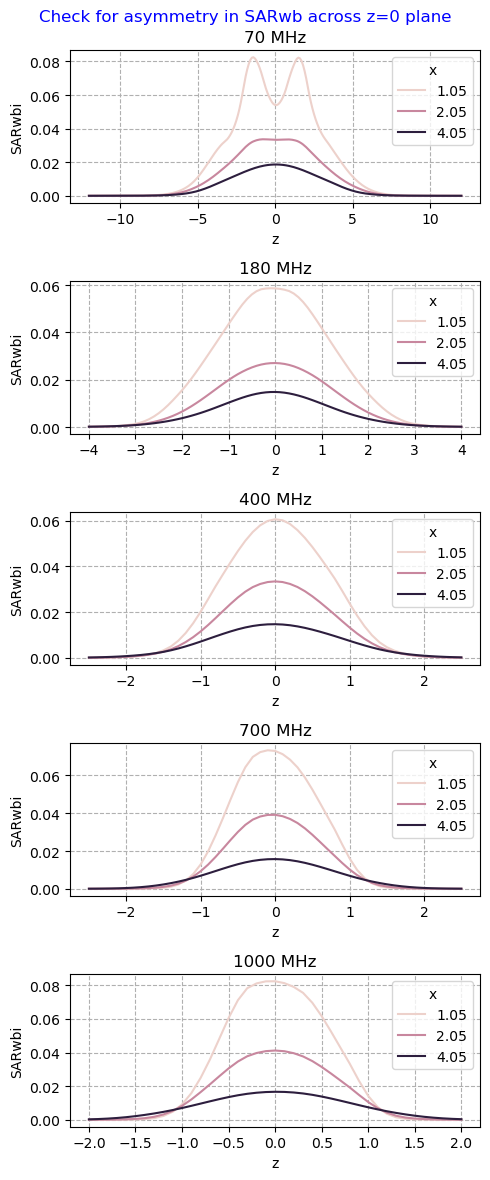

In [24]:
# Bar plots of dB(SARwb) along z for various values of x and y
SARdfi = SARdfi_all.copy()
SARdfi['dB(SARwbi)'] = dB(SARdfi.SARwbi)
xvals = [1.05,2.05,4.05]

fig, ax = plt.subplots(len(trials),1,figsize=(5,12))
plt.suptitle(f"Check for asymmetry in SARwb across z=0 plane",fontsize=12,c='b')

for i, trial in enumerate(trials):
    mask = (SARdfi.x.isin(xvals)) & (SARdfi.trial==trial)
    t = trialdata[str(trial)]
    sn.lineplot(SARdfi[mask],x='z',y='SARwbi',hue='x',ax=ax[i])
    ax[i].set_title(f'{t.fMHz} MHz')
    ax[i].grid(ls='--')
    plt.tight_layout();

Data looks nicely symmetric in the z axis, except very close to the antenna. It is *not* expected to be perfectly symmetric since the body phantom is not totally symmetric in the z direction

### Merge Sall and SARdfi_xyz with S
*Don't* merge in **SARdfall** since some of the SARwb points, e.g. y=0.36, x=0.81, are not on the 0.1m grid spacing

In [25]:
# Create Sall by merging SARwb and SARps from SARdf with S dataframe
Sall = S.merge(SARdfi_all,how='left',on=['trial','x','y','z']).sort_values(['trial','x','y','z'],ignore_index=True)
Sall.head()

,trial,fMHz,x,y,z,rxy,SE,SH,Smax,SARwbi
0,4,70,0.05,0.0,-12.0,0.05,0.000485,6.529958e-07,0.000485,0.000014
1,4,70,0.05,0.0,-11.9,0.05,0.000512,6.884640e-07,0.000512,0.000014
2,4,70,0.05,0.0,-11.8,0.05,0.000540,7.264836e-07,0.000540,0.000014
3,4,70,0.05,0.0,-11.7,0.05,0.000570,7.672851e-07,0.000570,0.000014
4,4,70,0.05,0.0,-11.6,0.05,0.000603,8.111243e-07,0.000603,0.000014


## Calculate spatial averages

In [26]:
# Set parameters
l, dl = 1.6, 0.1
mlist = [5,9,17]

# Set convolution vectors for 1.6m
clist = [conv_vector(l, dl, m) for m in mlist]
for m, c in zip(mlist,clist):
    print(f'{m:2d} points: sum{list(c.round(3))} = {sum(c)}')

# Set convolution vectors for 1.6m and Simpsons 1/3 rule
c5S13  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
c9S13  = [1,0,4,0,2,0,4,0,2,0,4,0,2,0,4,0,1]
c17S13 = [1,4,2,4,2,4,2,4,2,4,2,4,2,4,2,4,1]
clistS13 = [np.array(c) / sum(c) for c in (c5S13, c9S13, c17S13)]
for m, c in zip(mlist,clistS13):
    print(f'{m:2d} points: sum{list(c.round(3))} = {sum(c)}')

# # Smax
# sa_all = np.empty(0)
# for trial in trials:
#     mask = Sall.trial == trial
#     sa, name, title = spatavg(Sall[mask], f"Smax-{l}m-{m}",  "Smax",  c)
#     sa_all = np.concatenate([sa_all,sa])
# Sall[name] = sa_all

# # SE
# sa_all = np.empty(0)
# for trial in trials:
#     mask = Sall.trial == trial
#     sa, name, title = spatavg(Sall[mask], f"SE-{l}m-{m}",  "SE",  c)
#     sa_all = np.concatenate([sa_all,sa])
# Sall[name] = sa_all

# Create spatial averages for SE and Smax for clist items
for Si in ['Smax', 'SE']:
    for m, c in zip(mlist,clist):
        sa_all = np.empty(0)
        for trial in trials:
            mask = Sall.trial == trial
            name = f"{Si}-{l}m-{m}"
            sa = spatavg(Sall[mask], name, Si,  c)
            sa_all = np.concatenate([sa_all,sa])
        Sall[name] = sa_all
        
# Create spatial averages for SE and Smax clistS13 items
for Si in ['Smax', 'SE']:
    for m, c in zip(mlist,clistS13):
        sa_all = np.empty(0)
        for trial in trials:
            mask = Sall.trial == trial
            name = f"{Si}-{l}m-{m}-S13"
            sa = spatavg(Sall[mask], name, Si,  c)
            sa_all = np.concatenate([sa_all,sa])
        Sall[name] = sa_all

 5 points: sum[0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2] = 1.0
 9 points: sum[0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111] = 1.0000000000000002
17 points: sum[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059] = 1.0
 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
 9 points: sum[0.042, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.042] = 0.9999999999999999
17 points: sum[0.021, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.021] = 1.0
creating Smax-1.6m-5 spatial average of Smax
creating Smax-1.6m-5 spatial average of Smax
creating Smax-1.6m-5 spatial average of Smax
creating Smax-1.6m-5 spatial average of Smax
creating Smax-1.6m-5 spat

In [27]:
Sall.head()

,trial,fMHz,x,y,z,rxy,SE,SH,Smax,SARwbi,...,Smax-1.6m-17,SE-1.6m-5,SE-1.6m-9,SE-1.6m-17,Smax-1.6m-5-S13,Smax-1.6m-9-S13,Smax-1.6m-17-S13,SE-1.6m-5-S13,SE-1.6m-9-S13,SE-1.6m-17-S13
0,4,70,0.05,0.0,-12.0,0.05,0.000485,6.529958e-07,0.000485,0.000014,...,0.000323,0.000370,0.000340,0.000323,0.000345,0.000325,0.000315,0.000345,0.000325,0.000315
1,4,70,0.05,0.0,-11.9,0.05,0.000512,6.884640e-07,0.000512,0.000014,...,0.000371,0.000391,0.000360,0.000371,0.000365,0.000344,0.000374,0.000365,0.000344,0.000374
2,4,70,0.05,0.0,-11.8,0.05,0.000540,7.264836e-07,0.000540,0.000014,...,0.000422,0.000415,0.000436,0.000422,0.000387,0.000445,0.000416,0.000387,0.000445,0.000416
3,4,70,0.05,0.0,-11.7,0.05,0.000570,7.672851e-07,0.000570,0.000014,...,0.000475,0.000440,0.000462,0.000475,0.000410,0.000471,0.000481,0.000410,0.000471,0.000481
4,4,70,0.05,0.0,-11.6,0.05,0.000603,8.111243e-07,0.000603,0.000014,...,0.000533,0.000565,0.000544,0.000533,0.000597,0.000540,0.000530,0.000597,0.000540,0.000530


In [28]:
mask = (Sall.trial == 4)
Sall[mask].describe().T

,count,mean,std,min,25%,50%,75%,max
x,12291.0,2.550000e+00,1.472020,5.000000e-02,1.250000,2.550000,3.850000,5.050000
y,12291.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
z,12291.0,-7.399680e-17,6.957294,-1.200000e+01,-6.000000,0.000000,6.000000,12.000000
rxy,12291.0,2.550000e+00,1.472020,5.000000e-02,1.250000,2.550000,3.850000,5.050000
SE,12291.0,5.423291e+00,73.327842,3.867000e-04,0.002749,0.068629,0.527697,1915.457734
SH,12291.0,5.460671e+00,74.415659,6.528936e-07,0.001848,0.044737,0.525935,1978.096801
Smax,12291.0,8.722390e+00,100.484802,3.965858e-04,0.002847,0.068629,0.565796,1978.096801
SARwbi,12291.0,1.623579e-02,0.037386,5.210421e-06,0.000052,0.002048,0.016400,0.458670
Smax-1.6m-5,12291.0,8.722374e+00,84.400737,2.466118e-04,0.003189,0.085336,0.573529,1716.282117
Smax-1.6m-9,12291.0,8.722375e+00,85.378969,2.271681e-04,0.003125,0.082736,0.572975,1647.587918


## Draw plots

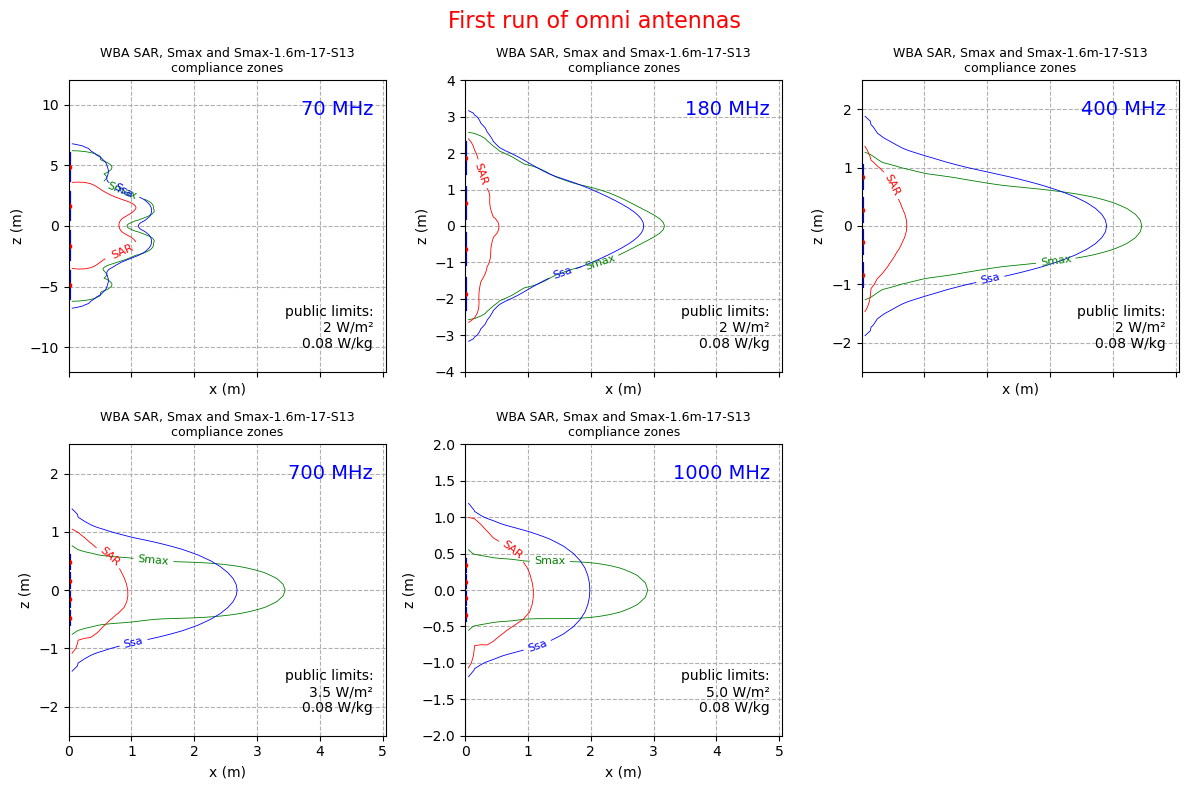

In [29]:
# Plot compliance boundaries
trials = [4,5,6,7,8]
Si = 'Smax-1.6m-17-S13'
rows, cols = 2, 3
fig, axes = plt.subplots(rows,cols,figsize=(12,8),sharex=True)

for i, trial in enumerate(trials):
    t = trialdata[str(trial)]
    mask = Sall.trial == trial
    complot(Sall[mask],t.fMHz,'public',S=Si,axes=axes,axi=i, plot_title='First run of omni antennas')
axes[1,2].remove()


## R, compliance ratios

70 MHz: S limit = 2 W/m², SAR limit = 0.08 W/kg


0        0.000370
1        0.000391
2        0.000415
3        0.000440
4        0.000565
           ...   
12286    0.000343
12287    0.000257
12288    0.000253
12289    0.000249
12290    0.000247
Name: Smax-1.6m-5, Length: 12291, dtype: float64

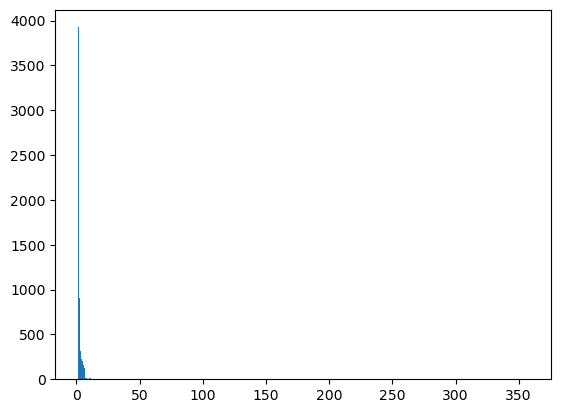

In [30]:
trial = 4
t = trialdata[str(trial)]
limS = Slimit(t.fMHz, setting='pub', standard='RPS S-1 WB')
limSAR = SARlimit('pub')
print(f'{t.fMHz} MHz: S limit = {limS} W/m², SAR limit = {limSAR} W/kg')

mask = (Sall.trial == trial)
df = Sall[mask]
Si = "Smax-1.6m-5"
R = (df[Si]/limS) / (df.SARwbi/limSAR)
plt.hist(R,bins=1000);
# plt.xlim(0,4)
df[Si]

## Check SARwb values

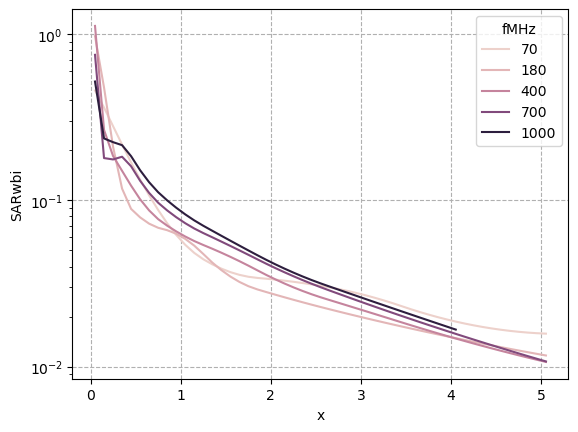

In [31]:
mask = Sall.z==0
sn.lineplot(data=Sall[mask], x='x', y='SARwbi', hue='fMHz')
plt.grid(ls='--')
plt.yscale("log");

In [32]:
# Check SARwbi values against Dimbylow value
SARdimb = 19.84E-6
Edimb = 1
df0 = Sall.query("z==0 & x==4.05")
display(df0)
SARwbi = df0['SARwbi'].values[0]
Spoint = df0['SE-1.6m-5-S13'].values[0]
Epoint = np.sqrt(377*Spoint)
SARwbi_scaled = SARwbi * (Edimb / Epoint)**2
print(f'SAR Dimbylow = {SARdimb*1E6} µW/kg, scaled FEKO SARwbi = {SARwbi_scaled*1E6} µW/kg')

,trial,fMHz,x,y,z,rxy,SE,SH,Smax,SARwbi,...,Smax-1.6m-17,SE-1.6m-5,SE-1.6m-9,SE-1.6m-17,Smax-1.6m-5-S13,Smax-1.6m-9-S13,Smax-1.6m-17-S13,SE-1.6m-5-S13,SE-1.6m-9-S13,SE-1.6m-17-S13
9760,4,70,4.05,0.0,0.0,4.05,0.585203,0.597287,0.597287,0.018649,...,0.589963,0.570467,0.572849,0.574046,0.590777,0.590778,0.590778,0.575260,0.575248,0.575248
15571,5,180,4.05,0.0,0.0,4.05,1.498787,1.575989,1.575989,0.014827,...,1.378206,1.284103,1.316038,1.332288,1.397819,1.397354,1.397327,1.349212,1.348820,1.348797
18487,6,400,4.05,0.0,0.0,4.05,2.333148,2.377155,2.377155,0.014750,...,1.849440,1.698070,1.783628,1.827873,1.898392,1.896563,1.896263,1.874720,1.873490,1.873414
21088,7,700,4.05,0.0,0.0,4.05,2.551372,2.570641,2.570641,0.015730,...,1.949225,1.786165,1.887179,1.939593,2.005666,2.004081,2.003897,1.995164,1.993774,1.993686
23284,8,1000,4.05,0.0,0.0,4.05,2.608815,2.620513,2.620513,0.016693,...,1.973774,1.807808,1.912972,1.967591,2.032145,2.030682,2.030571,2.025509,2.024088,2.023997


SAR Dimbylow = 19.84 µW/kg, scaled FEKO SARwbi = 85.98881373948849 µW/kg


In [33]:
# IEC 62232 (2018) SAR formula values
d = 4     # m
body = 'adult'
fMHz = 1000  # MHz
P = 100      # W
N = 4 
DdBi = 7.38
L = 9.166    # m
Φdeg = 360   # horizontal HPBW in degrees
Θdeg = 20.3  # vertical HPBW in degress
SARwbIEC, SAR10g, SAR1g = SAR_IEC_front(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)
print(SARwbIEC)

0.0039013634476601135


In [34]:
# IEC 62232 2018 validation values
df0 = Sall.query("z==0")
dlist = df0.x.values
body = 'adult'
fMHz = t.fMHz  # MHz
P = t.Prad     # W
N = 4
DdBi = t.dBiGain
L = omni_length(fMHz)  # m
Φdeg = 360  # t.horizHPBW   # horizontal HPBW in degrees
Θdeg = t.vertHPBW    # vertical HPBW in degress

if fMHz >= 300:
    IECdatalist = [[d, SAR_IEC_front(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)[0]] for d in dlist]
    dfIEC = pd.DataFrame(IECdatalist,columns=('x','SARwbIEC'))
    dfIEC = pd.merge(df0,dfIEC,on='x')
    dfIEC['ratio'] = dfIEC.SARwbi / dfIEC.SARwbIEC
    display(dfIEC.tail())

    fig,ax = plt.subplots()
    dfIEC.plot('x','ratio',ax=ax,marker='o',label=f'{t.fMHz} MHz')
    ax.grid(ls='--')
    ax.set_title(r'Ratio of $\frac{SAR_{wb}}{SAR_{wbIEC}}$',fontsize=16)
    ax.set_ylim(0)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('ratio')
    ax.hlines(1, 0, 5, lw=2, ls='--', color='g')
    fig.savefig('SAR compare 400 MHz.png')

In [35]:
# Check S value in far(ish) field at z=0, x=5.05
d = S.x.max()

Smax1 = S[(S.z==0) & (S.x==d)]
display(Smax1)

G = 10**(DdBi/10)
Scalc = P * G / (4 * np.pi * d**2)
Scalc


,trial,fMHz,x,y,z,rxy,SE,SH,Smax
12170,4,70,5.05,0.0,0.0,5.05,0.456997,0.456626,0.456997
4090,5,180,5.05,0.0,0.0,5.05,1.151565,1.201397,1.201397
2575,6,400,5.05,0.0,0.0,5.05,1.573959,1.594588,1.594588
2575,7,700,5.05,0.0,0.0,5.05,1.666553,1.675580,1.675580


1.702971499341942

## Scratch

### Create dummy data

In [29]:
def radiator(x0, y0, X, Y, PG):
    '''Calculate S for isotropic radiator on located at x0, y0
       on X, Y meshgrid for PG=power*gain'''
    r2 = (X-x0)**2 + (Y-y0)**2
    rsmall = X[0,1] - X[0,0]
    r2[r2==0] = (rsmall/4)**2  #Set small non zero value for r2 at r2 = 0
    S = PG / (4*np.pi*r2)
    return S

In [30]:
PG = 10
delta = 0.1
x = np.arange(0, 6+delta, delta)
y = np.arange(-3.0, 3.0+delta, delta) 
X, Y = np.meshgrid(x, y)
S1 = radiator(0,-1,X,Y,PG)
S2 = radiator(0,0,X,Y,PG)
S3 = radiator(0,1,X,Y,PG)
S = S1 + S2 + S3
SAR = S/2

In [6]:
import numpy as np
fMHz = 400
S = RFcalcUC.Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
g = 7.4
G = 10 ** (g/10)
P = 100
d = np.sqrt(P * G /(4 * np.pi * S))
ic(S,d)

ic| S: 2, d: 4.676059946832393


(2, 4.676059946832393)

,x,y,r
0,-4.520040e-01,-2.133939e-01,0.249845
1,-4.582338e-01,-2.000000e-01,0.249978
2,-4.683585e-01,-1.750000e-01,0.249985
3,-4.750000e-01,-1.558051e-01,0.249900
4,-4.769655e-01,-1.500000e-01,0.249996
5,-4.841137e-01,-1.250000e-01,0.249991
6,-4.898917e-01,-1.000000e-01,0.249994
7,-4.943404e-01,-7.500000e-02,0.249997
8,-4.974931e-01,-5.000000e-02,0.249999
9,-4.993746e-01,-2.500000e-02,0.250000


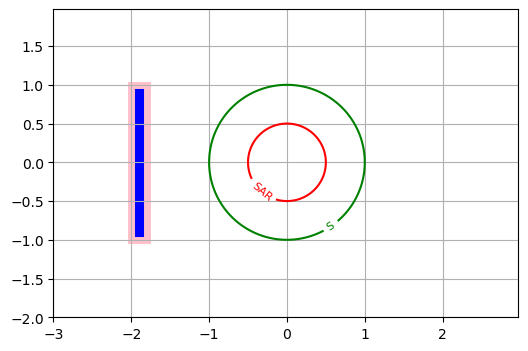

In [2]:
# Made up data for testing plots
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta) 
X, Y = np.meshgrid(x, y)
Z1 = np.sqrt(X**2 + Y**2)
Z2 = 2 * np.sqrt(X**2 + Y**2)

# Create figure
fig1, ax1 = plt.subplots(figsize=[6,4])

# Basic contour plots for two sets of data
limit = 1
CS1 = ax1.contour(X, Y, Z1, levels=[limit], colors=['green'])
CS2 = ax1.contour(X, Y, Z2, levels=[limit], colors=['red'])
ax1.grid()

# Add named contour lables at Z=1 for each data set
fmt1 = {limit:'S'}
fmt2 = {limit:'SAR'}

# Label every other level using strings
ax1.clabel(CS1, CS1.levels, inline=True, fmt=fmt1, fontsize=8)
ax1.clabel(CS2, CS2.levels, inline=True, fmt=fmt2, fontsize=8)

# Add antenna box
ax1.add_patch(Rectangle((-2, -1), 0.2, 2,
              edgecolor = 'pink',
              facecolor = 'blue',
              fill=True,
              lw=5))

# ax1.legend([CS1,CS2], ['first', 'second']);

#add rectangle to plot
# ax.add_patch(Rectangle((1, 1), 2, 6,
#              edgecolor = 'pink',
#              facecolor = 'blue',
#              fill=True,
#              lw=5))

for item in CS2.collections:
    for i in item.get_paths():
        v = i.vertices
        x = v[:, 0]
        y = v[:, 1]
        df = pd.DataFrame(dict(x=x,y=y))
        df['r'] = df.x**2 + df.y**2
        display(df)

[4. 4.] [4. 4.]
[4.  3.5] [3.5 4. ]
[4. 4. 3. 3.] [3. 3. 4. 4.]
[4.         3.33333333 3.         2.5       ] [2.5        3.         3.33333333 4.        ]
[4.         4.         3.         2.66666667 2.         2.        ] [2.         2.         2.66666667 3.         4.         4.        ]
[4.  3.  3.  2.  2.  1.5] [1.5 2.  2.  3.  3.  4. ]
[4.         3.         2.         2.         1.33333333 1.        ] [1.         1.33333333 2.         2.         3.         4.        ]
[2. 1.] [1. 2.]


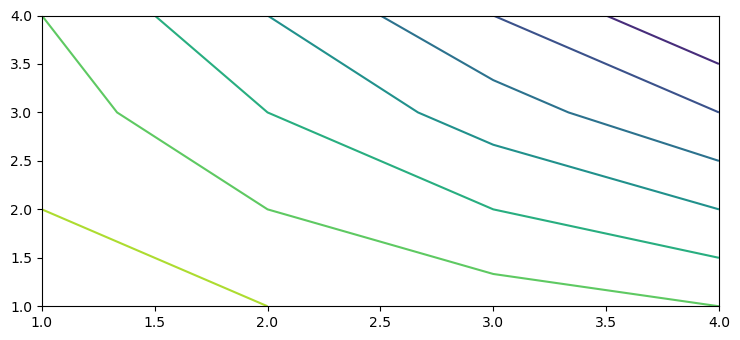

In [81]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = [1, 2, 3, 4]
y = [1, 2, 3, 4]
m = [[15, 14, 13, 12], [14, 12, 10, 8], [13, 10, 7, 4], [12, 8, 4, 0]]

cs = plt.contour(x, y, m)

for item in cs.collections:
   for i in item.get_paths():
      v = i.vertices
      x = v[:, 0]
      y = v[:, 1]
      print(x, y)
plt.show()

In [43]:
dir(CS1)
# CS1.axes.lines

['_A',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_label',
 '_algorithm',
 '_autolev',
 '_check_xyz',
 '_clabel_zorder',
 '_contour_args',
 '_contour_generator',
 '_contour_zorder',
 '_corner_mask',
 '_extend_max',
 '_extend_min',
 '_get_allsegs_and_allkinds',
 '_get_label_clabeltext',
 '_get_label_text',
 '_get_lowers_and_uppers',
 '_get_nth_label_width',
 '_id_norm',
 '_initialize_x_y',
 '_levels',
 '_make_paths',
 '_maxs',
 '_mins',
 '_norm',
 '_process_args',
 '_process_colors',
 '_process_contour_level_args',
 '_process_levels',
 '_process_linestyles',
 '_process_linewidths',
 '_scale_norm',
 '_transform',
 '_use_clabeltext',
 'add_label

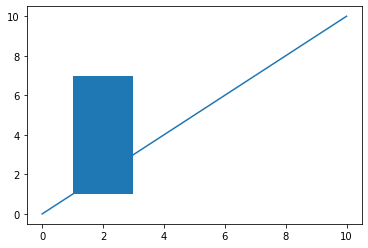

In [3]:
from matplotlib.patches import Rectangle

#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot([0, 10],[0, 10])

#add rectangle to plot
ax.add_patch(Rectangle((1, 1), 2, 6))


(array([2.5, 1. , 1. , 4. ]),
 array([0.5, 1.5, 2.5, 3.5, 4.5]),
 <BarContainer object of 4 artists>)

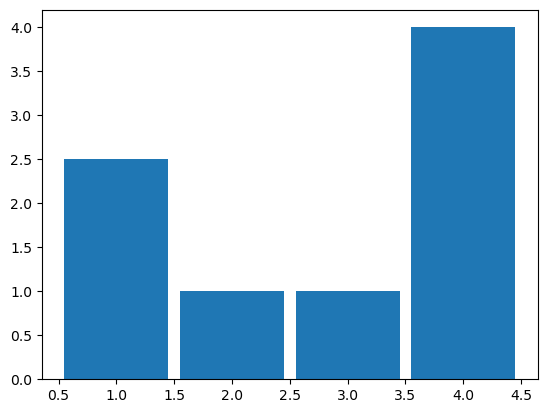

In [210]:
x = [1,2,3,4]
w = [2.5,1,1,4]
plt.hist(x, bins=np.arange(0.5,5.5,1), weights=w, rwidth=0.9)

In [40]:
# Get weighted average
x = [1,2,3,4]
w = [1,1,1,2]
np.average(x, weights=w)

2.8

### Weighted percentiles

#### Unweighted solution

array([-1.9689,  1.9509])

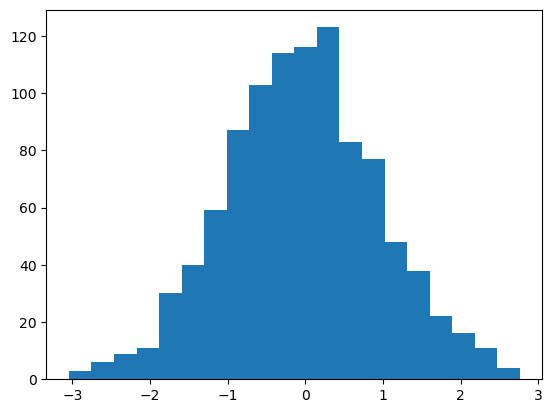

In [148]:
np.random.seed(0)
n = 1000
w = np.ones(n)
x = np.random.normal(0,1,n)
plt.hist(x,bins=20)
np.percentile(x,[2.5,97.5],method='linear').round(4)

#### Solution 1
see: https://kochanski.org/gpk/code/speechresearch/gmisclib/gmisclib.weighted_percentile-pysrc.html#wp

In [77]:
def wp(data, wt, percentiles): 
    """Compute weighted percentiles. 
    If the weights are equal, this is the same as normal percentiles. 
    Elements of the C{data} and C{wt} arrays correspond to 
    each other and must have equal length (unless C{wt} is C{None}). 

    @param data: The data. 
    @type data: A L{numpy.ndarray} array or a C{list} of numbers. 
    @param wt: How important is a given piece of data. 
    @type wt: C{None} or a L{numpy.ndarray} array or a C{list} of numbers. 
            All the weights must be non-negative and the sum must be 
            greater than zero. 
    @param percentiles: what percentiles to use.  (Not really percentiles, 
            as the range is 0-1 rather than 0-100.) 
    @type percentiles: a C{list} of numbers between 0 and 1. 
    @rtype: [ C{float}, ... ] 
    @return: the weighted percentiles of the data. 
    """ 
    assert np.greater_equal(percentiles, 0.0).all(), "Percentiles less than zero" 
    assert np.less_equal(percentiles, 1.0).all(), "Percentiles greater than one" 
    data = np.asarray(data) 
    assert len(data.shape) == 1 
    if wt is None:
        wt = np.ones(data.shape, float) 
    else: 
        wt = np.asarray(wt, float) 
        assert wt.shape == data.shape, "data and wt must have same shape" 
        assert np.greater_equal(wt, 0.0).all(), "Not all weights are non-negative." 
    assert len(wt.shape) == 1 
    n = data.shape[0] 
    assert n > 0 
    i = np.argsort(data) 
    sd = np.take(data, i, axis=0) 
    sw = np.take(wt, i, axis=0) 
    aw = np.add.accumulate(sw) 
    if not aw[-1] > 0: 
        raise ValueError("Nonpositive weight sum")
    w = (aw-0.5*sw)/aw[-1] 
    spots = np.searchsorted(w, percentiles) 
    o = [] 
    for (s, p) in zip(spots, percentiles): 
        if s == 0: 
            o.append(sd[0]) 
        elif s == n: 
            o.append(sd[n-1]) 
        else: 
            f1 = (w[s] - p)/(w[s] - w[s-1]) 
            f2 = (p - w[s-1])/(w[s] - w[s-1]) 
            assert f1>=0 and f2>=0 and f1<=1 and f2<=1 
            assert abs(f1+f2-1.0) < 1e-6 
            o.append(sd[s-1]*f1 + sd[s]*f2) 
    return o 

In [79]:
print(np.round(wp(x,None,[0.025,0.975]),4))
print(np.round(wp(x,w,[0.025,0.975]),4))

[-1.9747  1.9533]
[-1.9747  1.9533]


#### Solution 2

In [65]:
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

In [82]:
p = weighted_percentile(x, w, [0.025,0.975])
print(np.round(p,4))

[-1.9747  1.9533]


#### Solution 3
This solution does indeed give the same answers as np.percentile for unweighted arrays

See: https://stackoverflow.com/a/32216049/2918893

In [151]:
def weighted_percentile(a, q=[2.5, 97.5], w=None):
    """
    Calculates percentiles associated with a (possibly weighted) array

    Parameters
    ----------
    a : array-like
        The input array from which to calculate percents
    q : array-like
        The percentiles to calculate (0.0 - 100.0)
    w : array-like, optional
        The weights to assign to values of a.  Equal weighting if None
        is specified

    Returns
    -------
    values : np.array
        The values associated with the specified percentiles.  
    """
    # Force a, q and w to numpy arrays
    a = np.asarray(a)
    if not isinstance(q, Iterable):
        q = [q]
    q = np.asarray(q) / 100.0
    if w is None:
        w = np.ones(a.size)
    else:
        w = np.asarray(w)
        
    # Standardize and sort based on values in a
    idx = np.argsort(a)
    a_sort = a[idx]
    w_sort = w[idx]

    # Get the cumulative sum of weights
    ecdf = np.cumsum(w_sort)

    # Find the percentile index positions associated with the percentiles
    p = q * (w.sum() - 1)

    # Find the bounding indices (both low and high)
    idx_low = np.searchsorted(ecdf, p, side='right')
    idx_high = np.searchsorted(ecdf, p + 1, side='right')
    idx_high[idx_high > ecdf.size - 1] = ecdf.size - 1

    # Calculate the weights 
    weights_high = p - np.floor(p)
    weights_low = 1.0 - weights_high

    # Extract the low/high indexes and multiply by the corresponding weights
    x1 = np.take(a_sort, idx_low) * weights_low
    x2 = np.take(a_sort, idx_high) * weights_high

    # Return the average
    return np.add(x1, x2)

In [129]:
p = weighted_percentile(x, 2.5, w)
print(np.round(p,4))

[-1.9689]


In [132]:
x2 = [1,2,2,3,3,3]
w2 = [1,1,1,1,1,1]
p2 = weighted_percentile(x2, [2.5,97.5], w2)
print(p2)
      
x3 = [1,2,3]
w3 = [1,2,3]
p3 = weighted_percentile(x3, [2.5,97.5], w3)
print(p3)

[1.125 3.   ]
[1.125 3.   ]


#### Solution 4
See: https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html

In [143]:
from statsmodels.stats.weightstats import DescrStatsW

s = DescrStatsW(x, w)
s.quantile([0.025,.975])

# p4 = weighted_percentile(x4, 50, w4)
# print(p4)


p
0.025   -1.974711
0.975    1.953344
dtype: float64